<a href="https://colab.research.google.com/github/Jlokkerbol/masterclass/blob/main/2_0_data_preparation_DSBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation
In this notebook we will go through the data preparation phase. Steps such as cleaning up data, filling in missing values, selecting relevant features and defining outcomes are part of this phase. We will again follow the osteoarthritis case study that we also used last week. We will make use of the functionalities that Pandas offers for working with data. The data set we will work with today, is an extended version of the data set you saw last week. There are some more data features and outcomes.


## Objectives Data Preparation

### Making the data 'tidy'

- Each variable must have its own column
- Each observation must have its own row
- Each value must have its own cell

### Selecting relevant information 

- Select appropriate observations 
- Select available features
- Select useful features

### Cleaning data

- Clean inconsistencies
- Handle missing data
- Setting appropriate data types

### Constructing data

- Define outcome Y (clustered classes, categories)
- Redefine and/or construct features (feature engineering)
- Decide if and how to handle correlated input features

# Background to osteoarthritis case study

_taken from [narrative seminar Osteoarthritis by Hunter & Bierma-Zeinstra (2019) in the Lancet](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/hunter2019osteaoarthritis.pdf)._

Outcomes from total joint replacement can be optimised if patient selection identifies marked joint space narrowing. Most improvement will be made in patients with complete joint space loss and evident bone attrition. Up to 25% of patients presenting for total joint replacement continue to complain of pain and disability one year after (well-performed) surgery. Careful preoperative patient selection (including consideration of the poor outcomes that are more common in people who are depressed, have minimal radiographic disease, have minimal pain, and who are morbidly obese), shared decision making about surgery, and informing patients about realistic outcomes of surgery are needed to minimise the likelihood of dissatisfaction.

__Recap from previous lecture__
- Good outcome for knee replacement Y is measured using difference in Oxford Knee Score (OKS)
- Research has shown that an improvement in OKS score of approx. 30% is relevant ([van der Wees 2017](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/vanderwees2017patient-reported.pdf)). Hence an increase of +14 points is considered a 'good' outcome.
- to account for the ceiling effect, a high final `t1_oks_score` is also considered as a good outcome (even if `delta_oks_score` is smaller than 14).

# Importing data, libraries and style settings
We will first import some relevant packages, the data, and set some style options to generate nice plots. Besides some of the packages you already know, we also import seaborn, a library that can create some special plots, and Scikit-learn (sklearn), which is the most important machine learning library for Python. We will see more of the Scikit-learn functionality in the next practical sessions, when we will start training machine learning models.

In [17]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2, VarianceThreshold
from sklearn.model_selection import train_test_split
import sklearn.linear_model


#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

# import data
df_raw = pd.read_parquet('https://github.com/jads-nl/execute-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

# Understanding data with Pandas
In this step, we quickly recap what we learned about the data last week. As you have seen in the Pandas introduction, the library has some useful functions to understand your data at a glance. Below an overview of the data statistics for all features.

In [18]:
# Display data information such as data types
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139236 entries, 0 to 139235
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   provider_code                 139236 non-null  category
 1   procedure                     139236 non-null  category
 2   revision_flag                 139236 non-null  uint8   
 3   year                          139236 non-null  category
 4   age_band                      129834 non-null  category
 5   gender                        129834 non-null  float32 
 6   t0_assisted                   139236 non-null  uint8   
 7   t0_assisted_by                139236 non-null  uint8   
 8   t0_symptom_period             139236 non-null  uint8   
 9   t0_previous_surgery           139236 non-null  uint8   
 10  t0_living_arrangements        139236 non-null  uint8   
 11  t0_disability                 139236 non-null  uint8   
 12  heart_disease                 

As a quick reminder of last week, below an overview of the data statistics for all features.

In [19]:
# Display data statistics 
pd.set_option("display.precision", 2)
df_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
revision_flag,139236.0,0.04,0.19,0.00,0.00,0.00,0.00,1.00
gender,129834.0,1.57,0.49,1.00,1.00,2.00,2.00,2.00
t0_assisted,139236.0,1.92,0.82,1.00,2.00,2.00,2.00,9.00
t0_assisted_by,139236.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
t0_symptom_period,139236.0,2.65,1.05,1.00,2.00,2.00,3.00,9.00
t0_previous_surgery,139236.0,1.97,0.67,1.00,2.00,2.00,2.00,9.00
t0_living_arrangements,139236.0,1.35,1.04,1.00,1.00,1.00,1.00,9.00
t0_disability,139236.0,1.81,1.59,1.00,1.00,2.00,2.00,9.00
heart_disease,139236.0,8.25,2.33,1.00,9.00,9.00,9.00,9.00
high_bp,139236.0,5.46,3.97,1.00,1.00,9.00,9.00,9.00


# Making the data 'tidy'

This step is something that could take a lot of effort, but in our case we are lucky to be working with 'tidy' data already. 
* There is only one table to work with, so no merging or joining is needed
* Our rows correspond to the 'unit of analysis', just like we want them to
* Every column neatly contains one piece of information about our 'unit of analyses', so for every available replacement

# Selecting relevant information

The next step is selecting the available features (at the intended moment of modeling) and the relevant features (i.e. we exclude the obviously irrelevant features such as IDs, telephone numbers for example), and select a subset of the rows if necessary.

In [20]:
# List all the available features
list(df_raw.columns)

['provider_code',
 'procedure',
 'revision_flag',
 'year',
 'age_band',
 'gender',
 't0_assisted',
 't0_assisted_by',
 't0_symptom_period',
 't0_previous_surgery',
 't0_living_arrangements',
 't0_disability',
 'heart_disease',
 'high_bp',
 'stroke',
 'circulation',
 'lung_disease',
 'diabetes',
 'kidney_disease',
 'nervous_system',
 'liver_disease',
 'cancer',
 'depression',
 'arthritis',
 't0_mobility',
 't0_self_care',
 't0_activity',
 't0_discomfort',
 't0_anxiety',
 't0_eq5d_index_profile',
 't0_eq5d_index',
 't1_assisted',
 't1_assisted_by',
 't1_living_arrangements',
 't1_disability',
 't1_mobility',
 't1_self_care',
 't1_activity',
 't1_discomfort',
 't1_anxiety',
 't1_satisfaction',
 't1_sucess',
 't1_allergy',
 't1_bleeding',
 't1_wound',
 't1_urine',
 't1_further_surgery',
 't1_readmitted',
 't1_eq5d_index_profile',
 't1_eq5d_index',
 'oks_eq_5d_index_t1_predicted',
 't0_eq_vas',
 't1_eq_vas',
 'oks_eq_vas_t1_predicted',
 'oks_t0_pain',
 'oks_t0_night_pain',
 'oks_t0_washing'

You see that the list contains more features then last week. Features that are dependant on the moment of measurement are indicated with either `t0`, or `t1`.

There are also some extra outcomes beside the OKS score:

- Oxford Knee Score (OKS): a 12-item questionnaire that assess daily functioning c.q. disability due to knee osteoarthritis. Items are scored from [0,4], where higher is better (no disability).  
  - OKS question on pain and night pain, both on scale from [0,4]
  - OKS , higher is better. The OKS is a 12-item questionaire that assess daily functioning c.q. disability.
- EQ5D: generic quality of life PROMs along 5 dimensions on a 3-point Likert scale [1,3], lower is better. Dimensions are problems activity, anxiety, discomfort, mobility and self-care.
- EQ-VAS: general reported health on a scale from [0,100], higher is better.

We will explore the PROMs data to see which target variable Y is meaningful to assess the outcome of knee replacement. Note PROMs are measured at T0 (prior to surgery) and T1 (six months after surgery).
- [NHS PROMs methodology](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/nhs/proms_guide_v12.pdf)
- [NHS PROMs data dictionairy](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/nhs/proms_data_dictionary.pdf)

There are a number of `t1` variables that we cannot use at the time when we want the model to make a prediction, so we can exclude those variables from the analysis. For now we will leave in all the `t1` variables relating to the OKS that we will need when constructing our outcome Y. We will remove those after defining Y.

In [21]:
# remove t1 features that are not available for prediction
to_remove = ['t1_assisted', 't1_assisted_by', 't1_living_arrangements', 't1_disability', 't1_mobility', 't1_self_care',
             't1_activity', 't1_discomfort', 't1_anxiety', 't1_satisfaction', 't1_sucess', 't1_allergy', 't1_bleeding',
             't1_wound', 't1_urine', 't1_further_surgery', 't1_readmitted', 't1_eq5d_index_profile', 't1_eq5d_index']

df_temp = df_raw.drop(to_remove, axis=1)
list(df_temp.columns)

['provider_code',
 'procedure',
 'revision_flag',
 'year',
 'age_band',
 'gender',
 't0_assisted',
 't0_assisted_by',
 't0_symptom_period',
 't0_previous_surgery',
 't0_living_arrangements',
 't0_disability',
 'heart_disease',
 'high_bp',
 'stroke',
 'circulation',
 'lung_disease',
 'diabetes',
 'kidney_disease',
 'nervous_system',
 'liver_disease',
 'cancer',
 'depression',
 'arthritis',
 't0_mobility',
 't0_self_care',
 't0_activity',
 't0_discomfort',
 't0_anxiety',
 't0_eq5d_index_profile',
 't0_eq5d_index',
 'oks_eq_5d_index_t1_predicted',
 't0_eq_vas',
 't1_eq_vas',
 'oks_eq_vas_t1_predicted',
 'oks_t0_pain',
 'oks_t0_night_pain',
 'oks_t0_washing',
 'oks_t0_transport',
 'oks_t0_walking',
 'oks_t0_standing',
 'oks_t0_limping',
 'oks_t0_kneeling',
 'oks_t0_work',
 'oks_t0_confidence',
 'oks_t0_shopping',
 'oks_t0_stairs',
 'oks_t0_score',
 'oks_t1_pain',
 'oks_t1_night_pain',
 'oks_t1_washing',
 'oks_t1_transport',
 'oks_t1_walking',
 'oks_t1_standing',
 'oks_t1_limping',
 'oks_t1

In addition, domain experts deem a number of `t0` variables to be irrelevant: 't0_assisted_by' and 't0_eq5d_index_profile'. Can you remove these features from the data?

In [24]:
# remove irrelevant features
to_remove_t0 = ['t0_assisted_by' and 't0_eq5d_index_profile']

df_temp = df_temp.drop(to_remove_t0, axis=1)
list(df_temp.columns)

['provider_code',
 'procedure',
 'revision_flag',
 'year',
 'age_band',
 'gender',
 't0_assisted',
 't0_assisted_by',
 't0_symptom_period',
 't0_previous_surgery',
 't0_living_arrangements',
 't0_disability',
 'heart_disease',
 'high_bp',
 'stroke',
 'circulation',
 'lung_disease',
 'diabetes',
 'kidney_disease',
 'nervous_system',
 'liver_disease',
 'cancer',
 'depression',
 'arthritis',
 't0_mobility',
 't0_self_care',
 't0_activity',
 't0_discomfort',
 't0_anxiety',
 't0_eq5d_index',
 'oks_eq_5d_index_t1_predicted',
 't0_eq_vas',
 't1_eq_vas',
 'oks_eq_vas_t1_predicted',
 'oks_t0_pain',
 'oks_t0_night_pain',
 'oks_t0_washing',
 'oks_t0_transport',
 'oks_t0_walking',
 'oks_t0_standing',
 'oks_t0_limping',
 'oks_t0_kneeling',
 'oks_t0_work',
 'oks_t0_confidence',
 'oks_t0_shopping',
 'oks_t0_stairs',
 'oks_t0_score',
 'oks_t1_pain',
 'oks_t1_night_pain',
 'oks_t1_washing',
 'oks_t1_transport',
 'oks_t1_walking',
 'oks_t1_standing',
 'oks_t1_limping',
 'oks_t1_kneeling',
 'oks_t1_work'

During data understanding, we saw that the data was scarce on patients in the oldest and youngest age-brackets. For the sake of the example, let's suppose that we decide to take these age-brackets out of scope, meaning we exclude these records from our data.

In [25]:
# describe age_band information
df_temp['age_band'].value_counts()

age_band
70 to 79     55056
60 to 69     45361
80 to 89     15883
50 to 59     13260
40 to 49       250
90 to 120       24
Name: count, dtype: int64

Can you exclude rows corresponding to the highest and lowest age-bracket?

In [27]:
# Exclude rows corresponding to the highest and lowest age-bracket
df_temp = df_temp.drop(df_temp[df_temp.age_band == "40 to 49"].index)
df_temp = df_temp.drop(df_temp[df_temp.age_band == "90 to 120"].index)
df_temp['age_band'].value_counts()

age_band
70 to 79     55056
60 to 69     45361
80 to 89     15883
50 to 59     13260
40 to 49         0
90 to 120        0
Name: count, dtype: int64

In [28]:
# unused levels should be removed to further clean / prepare the data
df_temp.age_band = df_temp.age_band.cat.remove_unused_categories()
df_temp['age_band'].value_counts()

age_band
70 to 79    55056
60 to 69    45361
80 to 89    15883
50 to 59    13260
Name: count, dtype: int64

# Cleaning Data

In this step we handle missing values, correct any inconsistencies found in the data and set the appropriate data types. These data types are important for many of the models we will be training, as they make certain assumptions when a feature is for example of a 'category' type. So it's always good to use data types that match the actual nature of the data.

We start off with a straightforward imputation strategy, where we impute 
* numerical variables with the median value, and
* categorical variables with the most occurring level

In [29]:
# First we map all the missings in the data
df_temp.isnull().sum()

provider_code                       0
procedure                           0
revision_flag                       0
year                                0
age_band                         9402
gender                           9402
t0_assisted                         0
t0_assisted_by                      0
t0_symptom_period                   0
t0_previous_surgery                 0
t0_living_arrangements              0
t0_disability                       0
heart_disease                       0
high_bp                             0
stroke                              0
circulation                         0
lung_disease                        0
diabetes                            0
kidney_disease                      0
nervous_system                      0
liver_disease                       0
cancer                              0
depression                          0
arthritis                           0
t0_mobility                         0
t0_self_care                        0
t0_activity 

These are actually not all the missing. For some features a 9 is used to indicate a missing value. We need to identify those variables to be able to impute those 9s that actually refer to a missing value 

In [30]:
# list of all columns which contain 9s
cols_with_9 = [col for col in df_temp.columns if (df_temp[col]==9).any()]

# columns where 9 is *not* a sentinel value
comorb = ['heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease', 'diabetes',
           'kidney_disease', 'nervous_system', 'liver_disease', 'cancer', 'depression', 'arthritis']
cols_keep_9 = comorb + [ 't0_eq_vas', 't1_eq_vas','oks_t0_score', 'oks_t1_score']

# columns with 9 as sentinel value (the ^ operator performs an XOR test, keeping only features that are in cols_with_9, but not in cols_keep_9)
cols_sentinel_9 = list(set(cols_with_9) ^ set(cols_keep_9))
df_temp[cols_sentinel_9].head(20)


,t0_symptom_period,t0_mobility,oks_t1_night_pain,oks_t1_walking,oks_t0_washing,t0_discomfort,oks_t1_shopping,oks_t1_limping,oks_t1_stairs,oks_t0_walking,oks_t0_confidence,t0_self_care,oks_t1_confidence,oks_t1_pain,oks_t1_standing,t0_assisted,t0_disability,oks_t0_transport,t0_anxiety,oks_t0_limping,oks_t0_work,oks_t1_kneeling,t0_previous_surgery,t0_activity,oks_t0_standing,oks_t0_pain,oks_t1_transport,oks_t1_work,oks_t1_washing,oks_t0_night_pain,oks_t0_shopping,oks_t0_kneeling,oks_t0_stairs,t0_living_arrangements
0,2,2,3,3,2,2,4,4,3,2,2,1,4,3,3,2,1,2,1,0,1,2,2,2,2,0,3,4,4,1,2,1,2,2
1,2,9,4,4,4,9,4,4,4,0,3,9,3,4,4,2,2,4,9,1,4,3,2,9,4,1,3,3,4,4,4,4,4,2
2,2,9,4,4,4,9,4,4,4,2,3,9,4,4,4,2,2,4,9,2,3,2,2,9,4,1,4,4,4,4,3,3,4,1
3,2,9,2,1,2,9,4,4,3,2,3,9,3,3,4,2,1,2,9,2,1,1,2,9,2,1,4,3,4,2,3,0,2,2
4,3,2,2,2,4,9,2,3,1,2,0,1,3,2,3,1,1,2,1,0,1,2,2,2,1,0,2,2,4,1,0,1,0,2
5,4,2,1,2,4,9,3,3,3,3,4,1,4,1,3,1,2,4,1,3,2,1,2,2,2,0,4,2,3,1,2,1,3,1
6,3,1,4,4,4,2,4,4,3,4,3,1,4,3,3,2,2,3,1,3,3,2,2,1,2,1,4,3,4,2,3,2,2,1
7,2,2,4,4,2,2,4,4,4,2,0,2,4,4,3,2,1,1,1,1,0,3,2,3,1,0,3,4,4,1,1,0,1,1
8,3,2,3,1,3,3,0,3,1,2,1,1,3,3,3,2,1,2,1,2,2,1,2,2,1,0,2,3,4,1,0,1,1,2
9,2,2,4,4,4,2,4,4,4,2,2,1,4,4,4,1,2,4,1,3,2,4,2,2,3,1,4,4,4,2,3,0,3,1


Now we are ready to impute the missings using the median (for numeric variables) and most frequent value (for categorical variables). However, we first need to be aware of so-called 'data-leaking': 

When we impute missing values using information from other data instances, we are also using information from data instances that will end up in our test set. This will give our process of model development an unfair advantage, and will result in an overly optimistic assessment of model performance. 

Even though the degree of data-leakage is very small when imputing using the median and the most frequent value, the correct thing to do is to first split the data into a training and test set. Sklearn has a useful function for this.

In [31]:
# randomly splitting the data into a train and test set
df_train, df_test = train_test_split(df_temp, test_size=0.3, random_state=0)

Now we can impute the values in the training set, using the readily available functionality in the sklearn module. We work with a copy of the training data to be able to check our work and compare the imputed and not imputed versions of the data.

In [32]:
from sklearn.impute import SimpleImputer

impute_median = SimpleImputer(strategy='median')
impute_most_frequent = SimpleImputer(strategy='most_frequent')

# use copy of original data
dfc = df_train.copy()

# replace 9 with np.nan 
dfc.loc[:,cols_sentinel_9] = df_train.loc[:,cols_sentinel_9].replace(9, np.nan)

# determine most frequent value for imputation
impute_most_frequent.fit(dfc[cols_sentinel_9])
pd.DataFrame({'columns': cols_sentinel_9, 'most_frequent': impute_most_frequent.statistics_}).head(10)

,columns,most_frequent
0,t0_symptom_period,2.0
1,t0_mobility,2.0
2,oks_t1_night_pain,4.0
3,oks_t1_walking,4.0
4,oks_t0_washing,4.0
5,t0_discomfort,2.0
6,oks_t1_shopping,4.0
7,oks_t1_limping,4.0
8,oks_t1_stairs,4.0
9,oks_t0_walking,2.0


All the 9s in the relevant columns have now been replaced by missings. Can you print the missing values for all the columns that had 9 as a sentinel value?

In [33]:
# Print number of missing in columns with 9 as sentinal value
dfc[cols_sentinel_9].isnull().sum()

t0_symptom_period          844
t0_mobility               3045
oks_t1_night_pain          611
oks_t1_walking             883
oks_t0_washing              87
t0_discomfort             3936
oks_t1_shopping            696
oks_t1_limping             759
oks_t1_stairs              676
oks_t0_walking            1007
oks_t0_confidence          937
t0_self_care              3113
oks_t1_confidence          654
oks_t1_pain                881
oks_t1_standing            703
t0_assisted               1084
t0_disability             4116
oks_t0_transport           944
t0_anxiety                3638
oks_t0_limping             989
oks_t0_work                951
oks_t1_kneeling            757
t0_previous_surgery        745
t0_activity               3157
oks_t0_standing           1010
oks_t0_pain                133
oks_t1_transport           843
oks_t1_work                697
oks_t1_washing             843
oks_t0_night_pain          917
oks_t0_shopping            936
oks_t0_kneeling            977
oks_t0_s

And these can now be imputed using the most frequent values:

In [43]:
# assign most frequent data to the missing values for the selected columns
dfc.loc[:, cols_sentinel_9] = impute_most_frequent.transform(dfc[cols_sentinel_9])

After which all the missings in these columns have been replaced. Can you print the missing again?

In [ ]:
# print missing values
...

But these were not the only categorical variables with missing information. We have to do apply the same procedure to age_band and gender

In [35]:
# Print number of missings
dfc[['age_band', 'gender']].isnull().sum()

age_band    6551
gender      6551
dtype: int64

Can you find the most frequent values for the 'age_band' and 'gender' features?

In [46]:
# Find most frequent values
impute_most_frequent.fit(dfc[['age_band', 'gender']])
pd.DataFrame({'columns': ['age_band', 'gender'], 'most_frequent': impute_most_frequent.statistics_})

,columns,most_frequent
0,age_band,70 to 79
1,gender,2.0


And can you assign these most frequent values for the 'age_band' and 'gender' features?

In [47]:
# assign most frequent data to the missing values for the age and gender
dfc.loc[:, ['age_band', 'gender']] = impute_most_frequent.transform(dfc[['age_band', 'gender']])

In [48]:
# and our check:
dfc[['age_band', 'gender']].isnull().sum()

age_band    0
gender      0
dtype: int64

The eq_vas variables used 999 as sentinal values, so we can apply a similar procedure to these variables. As these variables contain numeric values, we use the median for imputation, rather than the most frequent value:

In [49]:
# same procedure for 999 sentinel values, using impute median
eq_vas = ['t0_eq_vas', 't1_eq_vas']
dfc.loc[:, eq_vas] = dfc.loc[:,eq_vas].replace(999, np.nan)


impute_median.fit(dfc.loc[:,eq_vas])
dfc.loc[:,eq_vas] = impute_median.transform(dfc[eq_vas])
impute_median.statistics_

array([70., 80.])

In [50]:
# again a check
dfc.isnull().sum()

provider_code                       0
procedure                           0
revision_flag                       0
year                                0
age_band                            0
gender                              0
t0_assisted                         0
t0_assisted_by                      0
t0_symptom_period                   0
t0_previous_surgery                 0
t0_living_arrangements              0
t0_disability                       0
heart_disease                       0
high_bp                             0
stroke                              0
circulation                         0
lung_disease                        0
diabetes                            0
kidney_disease                      0
nervous_system                      0
liver_disease                       0
cancer                              0
depression                          0
arthritis                           0
t0_mobility                         0
t0_self_care                        0
t0_activity 

There are still a few variables containing missings:
- t0_eq5d_index is a numeric variable which can be imputed using the median
- we will leave the missings in the t1_variables for now (oks_t1_score, oks_oks_t1_predicted, oks_eq_vas_t1_predicted and oks_eq_5d_index_t1_predicted)
- for the sake of the example, we can decide to exclude all instances where oks_t0_scores are missing, which has the implication that our model can only be applied in clinical practice to those patients for which oks_t0_scores are available.

In [51]:
# impute median for t0_eq5d_index
impute_median.fit(dfc.loc[:,'t0_eq5d_index'].to_frame())
dfc.loc[:,'t0_eq5d_index'] = impute_median.transform(dfc['t0_eq5d_index'].to_frame())
impute_median.statistics_

array([0.587], dtype=float32)

In [52]:
# remove instances with missing oks_t0_scores
dfc = dfc.dropna(subset=['oks_t0_score'])

## Convert data types

As we have seen last week, some features that actually indicate boolean variables were sometimes indicates with other values (like 1 and 9). We now transform variables into the suitable data type (True and False), such that the data are in the proper format for building models.

In [53]:
# transform into boolean
dfc['female'] = dfc.loc[:,'gender'].replace({1: False, 2: True})
dfc.loc[:, comorb] = dfc.loc[:, comorb].replace({9: False, 1: True})
boolean = ['t0_assisted', 't0_previous_surgery', 't0_disability']
dfc.loc[:, boolean] = dfc.loc[:, boolean].replace({1: True, 2: False})

With the function below, we can describe how often True and False occurs within these boolean values: 

In [54]:
# helper function for counting boolean attribues
def count_boolean(series):
    '''
    Returns absolute and normalized value counts of pd.series as a dataframe with 
    index = series.name
    columns with absolute and normalized counts of each value
    '''
    try:
        count = series.value_counts().to_frame().transpose()
        norm = series.value_counts(normalize=True).to_frame().transpose()
        return count.join(norm, lsuffix='_count', rsuffix='_normalized') 
    except:
        print('Error: expecting a pandas.Series object as input. \n' + count_boolean.__doc__)
        return None

pd.concat([count_boolean(dfc[col]) for col in ['female'] + comorb + boolean]).round(2)

,True_count,False_count,True_normalized,False_normalized
count,57483,38631,NaN,NaN
count,8936,87178,NaN,NaN
count,42362,53752,NaN,NaN
count,1588,94526,NaN,NaN
count,5417,90697,NaN,NaN
count,8763,87351,NaN,NaN
count,11920,84194,NaN,NaN
count,1923,94191,NaN,NaN
count,976,95138,NaN,NaN
count,533,95581,NaN,NaN


Finally, a few variables need to be defined as a categorical variable:

In [56]:
# convert to categories
dfc.loc[:, ['provider_code', 'age_band']] = dfc.loc[:, ['provider_code', 'age_band']].astype('category')

#Constructing data

In this final step of the data preparation, we get to the part where we make adjustments to the data:
- Defining the outcome Y
- Redefine and/or construct features (feature engineering, possibly handling correlated input features)

## Selecting outcome Y

Last week we already looked at defining a outcome way that can be used for predicting treatment success. This was based on knowledge from domain experts, which use the oks_score and whether the oks_score at t1 is above a certain threshold. We defined an outcome as good when the improvement in oks_score was larger than a minimum change threshold (chosen to be set at 13), OR when the absolute oks_score at t1 was above a certain threshold (chosen to be set at 43).

Here we will we have a look at an laternative (data-driven) approach to defining an outcome measure based on the data. 

In the [narrative on outcomes of osteoarthritis](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/hunter2019osteaoarthritis.pdf) it is stated that the [European League Against Rheumatism (EULAR)](https://eular.org) standard considers three primary symptoms, namely:
- Hip/knee pain
- Early morning stiffness (EMS)
- Functional limitations

Since we have no information on EMS, we take pain and functional limitations as the primary outcome parameters. We now turn to the NHS dataset to choose which (engineered) features are available as a measure for pain and physical functioning at `t1`.

## Feature engineering

We start off with adding three simple features
- a variable representing total pain, which is the sum of 'pain' and 'night_pain', 
- a variable representing total functioning, which is the sum of the OKS-scores on all the non-pain dimensions, and
- a variable representing the total number of comorbidities

It is common to start simple and return to and put more effort into feature engineering if model performance is deemed insufficient

In [57]:
# define total pain and total number of comorbidities
def oks_questions(t='t0'):
  return [f'oks_{t}_pain', f'oks_{t}_night_pain', f'oks_{t}_washing',
          f'oks_{t}_transport', f'oks_{t}_walking', f'oks_{t}_standing',
          f'oks_{t}_limping', f'oks_{t}_kneeling', f'oks_{t}_work',
          f'oks_{t}_confidence', f'oks_{t}_shopping', f'oks_{t}_stairs', ]

# combine that contain 'pain' to contstruct oks_pain_total and the rest for oks_functioning_total
for t in ("t0", "t1"):
    dfc[f"oks_{t}_pain_total"] = dfc[f"oks_{t}_pain"] + dfc[f"oks_{t}_night_pain"]
    dfc[f"oks_{t}_functioning_total"] = (
        dfc.loc[:, [col for col in oks_questions(t) if "pain" not in col]]
        .sum(axis=1)
    )
dfc["n_comorb"] = dfc.loc[:, comorb].sum()

### Pain measures
Let's plot a histogram of the different pain measure scores at t1 to get an idea of the distributions.

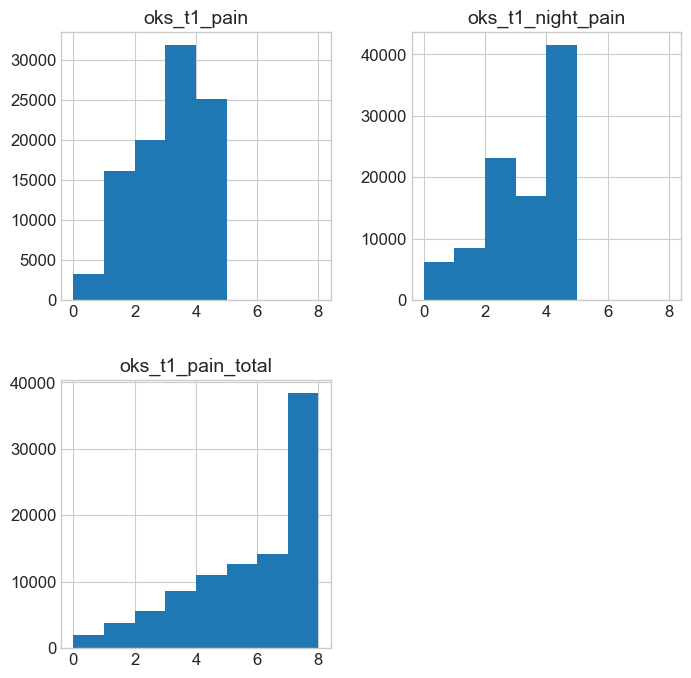

In [58]:
dfc[['oks_t1_pain', 'oks_t1_night_pain', 'oks_t1_pain_total']].hist(bins=range(0,9), figsize=S);

### Physical functioning
The same for the functioning measures.

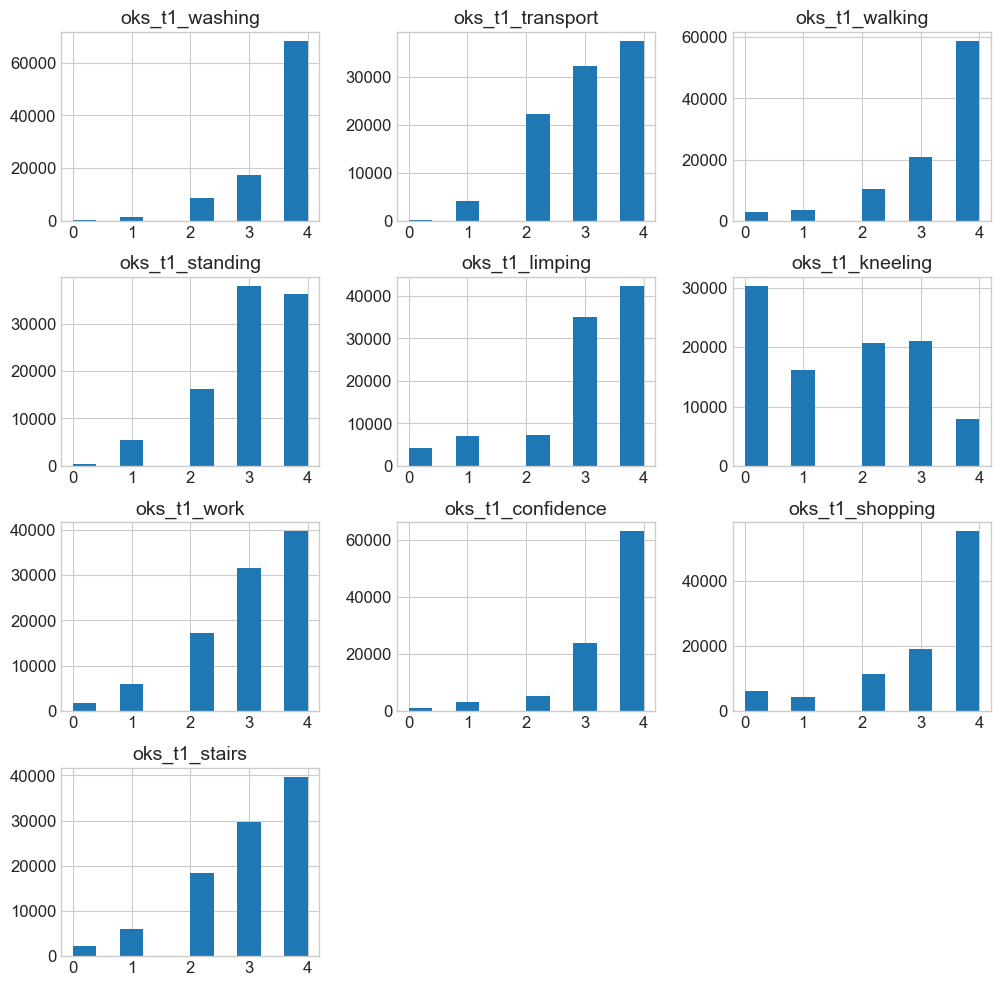

In [59]:
dfc.loc[:, [col for col in oks_questions("t1") if "pain" not in col],].hist(figsize=M);

And its total score.

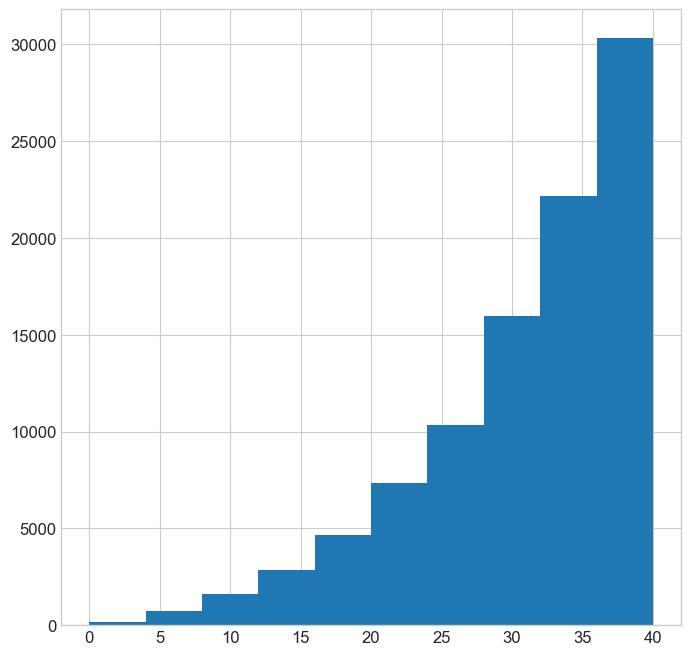

In [60]:
dfc['oks_t1_functioning_total'].hist(figsize=S);

### Combined outcome Y

Defining the appropriate outcome Y that meaningfully captures clinical change is a well-known challenge, see for example [development of psychometric tests](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/wise2004methods.pdf). 

Although this should always be defined with the help of domain experts, a data-driven approach to gather input on this decision could be to consider [the intersection between the 'pre' and 'post' histograms](http://blog.datadive.net/histogram-intersection-for-change-detection/), in this case pain and functioning measured at `t0` and `t1`.

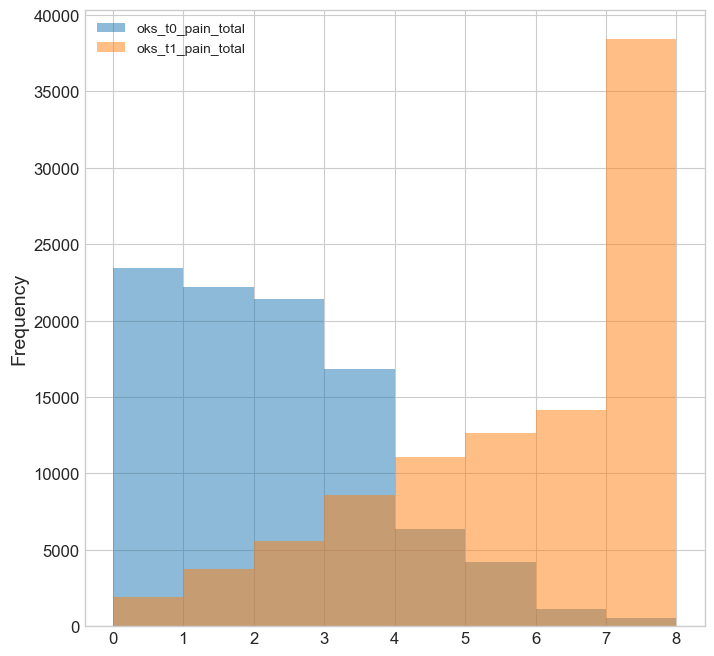

In [61]:
dfc[['oks_t0_pain_total', 'oks_t1_pain_total']].plot.hist(bins=range(0,9), alpha=0.5, figsize=S);

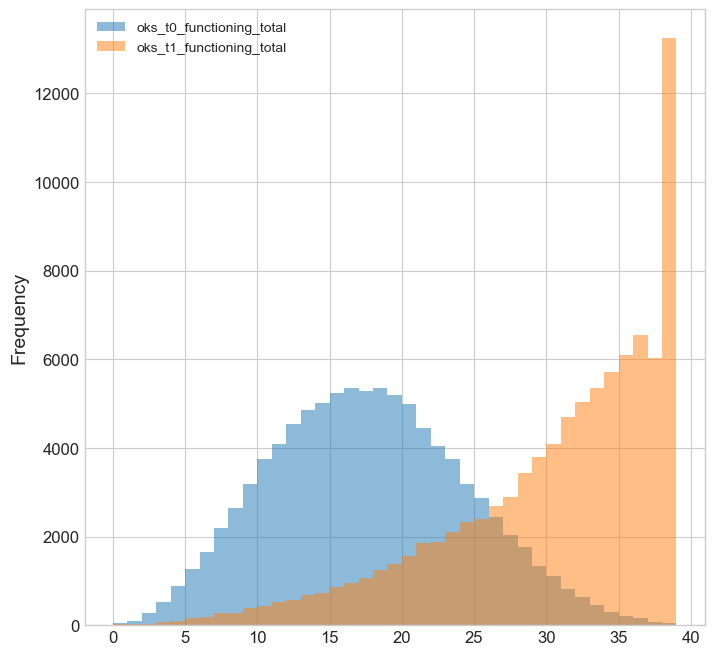

In [62]:
dfc[['oks_t0_functioning_total', 'oks_t1_functioning_total']].plot.hist(bins=range(0,40), alpha=0.5, figsize=S);

Using the histograms above, one way to combine pain and functioning into one outcome measure is to use the cut-off points:
- `oks_pain_total >= 4`: good outcome with less pain
- `oks_functioning_total >= 26`: good outcome with improved functioning

The figures below visualizes the combination of both measures to show that most people move from scoring poor on both pain and functioning at `t0` to scoring well on both of these measures at `t1`.

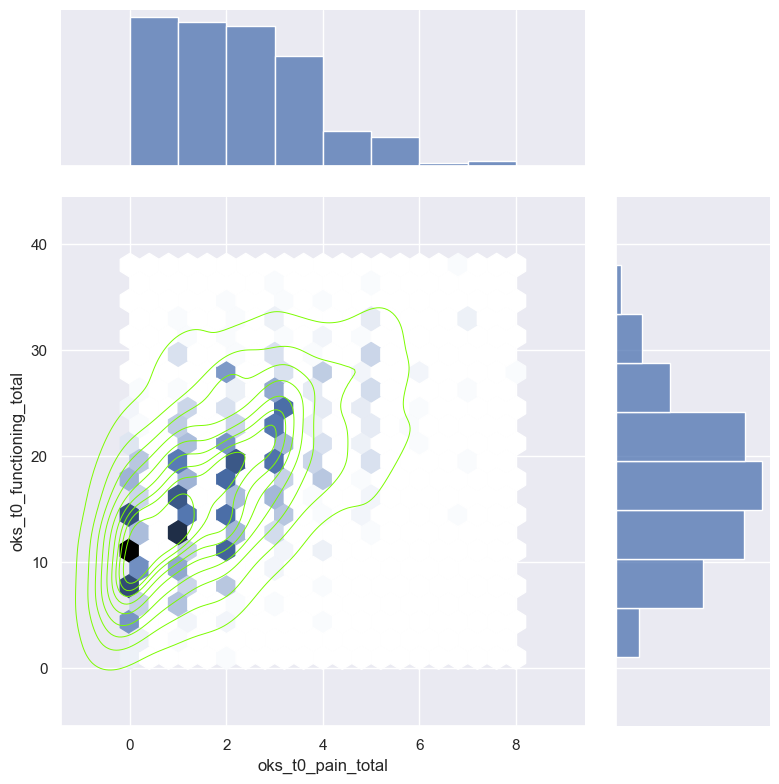

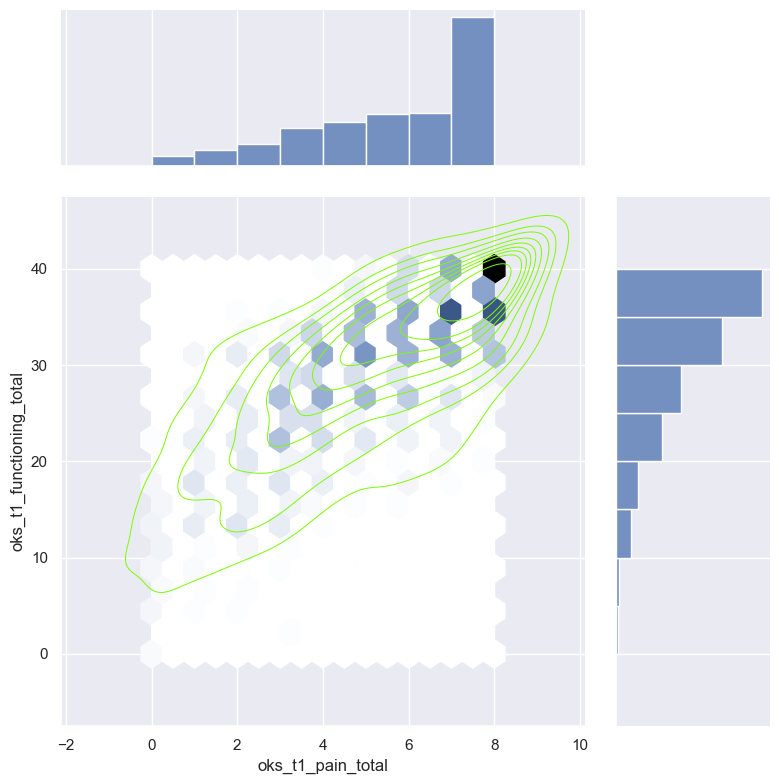

In [71]:
BINS = 8
SAMPLE = 1000

# https://stackoverflow.com/questions/45540886/reduce-line-width-of-seaborn-timeseries-plot
sns.set(rc={"lines.linewidth": 0.7})
fig1_layout = {
    'kind': "hex",
    'height': 8,
    'ratio': 3,
    'marginal_kws': {'bins': BINS, 'rug': False},
}
j1 = (sns.jointplot(
            x ='oks_t0_pain_total', y ='oks_t0_functioning_total',
            data=dfc[['oks_t0_pain_total', 'oks_t0_functioning_total']].head(SAMPLE),
            **fig1_layout).plot_joint(sns.kdeplot, color='lawngreen'))
j2 = (sns.jointplot(
            x ='oks_t1_pain_total', y ='oks_t1_functioning_total',
            data=dfc[['oks_t1_pain_total', 'oks_t1_functioning_total']].head(SAMPLE), 
            **fig1_layout).plot_joint(sns.kdeplot, color='lawngreen' ))

So let's add boolean columns indicating whether pain is 'good' (i.e. no pain) and functioning is good, both at `t0` and `t1`.

In [72]:
# add boolean columns
for t in ('t0', 't1'):
    dfc[f'y_{t}_pain_good'] = dfc[f'oks_{t}_pain_total'] >= 4
    dfc[f'y_{t}_functioning_good'] = dfc[f'oks_{t}_functioning_total'] >= 26

In [73]:
# inspect whether new features are correct
dfc[[col for col in dfc.columns if '_good' in col]].head(10)

,y_t0_pain_good,y_t0_functioning_good,y_t1_pain_good,y_t1_functioning_good
8990,False,True,True,True
30721,False,False,True,True
132380,True,False,True,True
26737,False,False,True,True
85796,False,False,True,False
127528,False,False,True,True
53492,False,False,False,False
41139,False,False,True,True
66788,False,False,True,True
138709,False,True,False,False


To get an idea how often the different combinations of True and False occur for these scores, before and after treatment, it is useful to print a frequency table. The crosstab function from Pandas is very useful for this. It describes the frequency with which the different True/False combinations occur in the data.

In [74]:
pd.crosstab(dfc.y_t0_pain_good, dfc.y_t0_functioning_good, normalize=True)

y_t0_functioning_good,False,True
y_t0_pain_good,,
False,0.81,0.07
True,0.08,0.05


Can you calculate the crosstab for at t1?

In [75]:
pd.crosstab(dfc.y_t1_pain_good, dfc.y_t1_functioning_good, normalize=True)

y_t1_functioning_good,False,True
y_t1_pain_good,,
False,0.15,0.06
True,0.08,0.71


On average, there seems to be a clear improvement based on the thresholds we have chosen. 71% has a good score on both engineered outcome measure, which is similar to the outcomes we defined last week based on domain expertise. Such an automatic, data-driven, approach can thus be a good solution if domain expertise is lacking or undefined.

## Conclusion and reflection

Today we have worked through the phase of data preparation. This involved the following steps: 

### Making the data 'tidy'

- Each variable must have its own column
- Each observation must have its own row
- Each value must have its own cell

### Selecting relevant information 

- Select appropriate observations 
- Select available features
- Select useful features

### Cleaning data

- Clean inconsistencies
- Handle missing data
- Setting appropriate data types

### Constructing data

- Define outcome Y (clustered classes, categories)
- Redefine and/or construct features (feature engineering)
- Decide if and how to handle correlated input features


You should expect to be returning to this stage of data preparation multiple times, trying to tweak the data such that model performance can further improve. As such, always make sure to set up your script / workflow in such a way that adjustments can be easily made.